In [1]:
from time import sleep
from os import chdir, mkdir
from os.path import isdir, isfile

try:
    chdir(r'A:\_Projetos\AnotacoesEstudosBackPythonLSP\Home\acoes')
except:
    chdir(r'C:\Users\GOMEE11\Documents\_Referencias\Git\AnotacoesEstudosBackPythonLSP\Home\acoes')

for d in ['.\\Graph', '.\\Tables']:
    if isdir(d):
        pass
    else:
        mkdir(d)
        pass

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from make_data import Down_Data, Analisys, Graph
import datetime

%matplotlib inline

# Analise individual de Ticker

### Analise Técnica

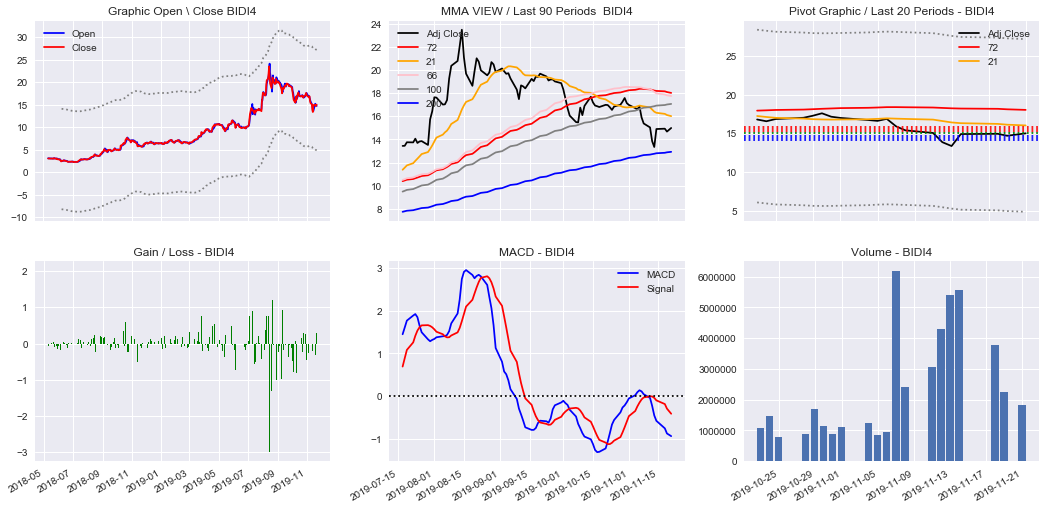

In [3]:
ticker = 'BIDI4'

target = Down_Data(ticker)
analise = Analisys(target, ticker)
graph = Graph(target, ticker)

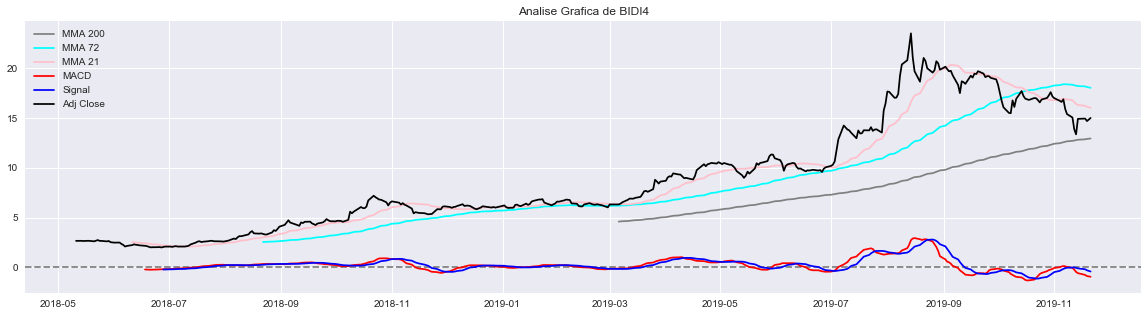

In [17]:
plt.figure(figsize=(20, 5))

plt.plot(analise['MMA200'], color='Grey', label='MMA 200')
plt.plot(analise['MMA72'], color='Cyan', label='MMA 72')
plt.plot(analise['MMA21'], color='Pink', label='MMA 21')

plt.axhline(0, color='Grey', linestyle="--")

plt.plot(analise['MACD'], color='Red', label='MACD')
plt.plot(analise['Signal'], color='Blue', label='Signal')

plt.plot(analise['Adj Close'], color='Black', label='Adj Close')


plt.title(f'Analise Grafica de {ticker}')

plt.legend()

plt.show()

## Euler Discratization

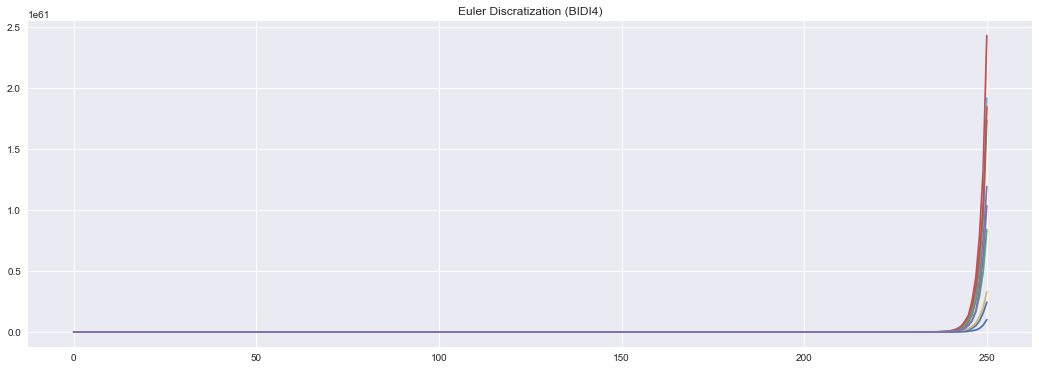

In [21]:
log_returns = np.log(1 + analise['Adj Close'].pct_change())
r = 0.025
stdev = log_returns.std() * 250 ** 0.5
#stdev = stdev.values
T = 1.0
t_intervals = 250
delta_t = T / t_intervals
iterations = 10000
z = np.random.standard_normal((t_intervals + 1, iterations))
s = np.zeros_like(z)
S0 = analise['Adj Close'].iloc[-1]
s[0] = S0

for t in range(1, t_intervals + 1):
    s[t] = s[t - 1] * np.exp((r - 0.5 * stdev **2) * delta_t + stdev + delta_t ** 0.5 * z[t])
    pass

plt.figure(figsize=(18,6))
plt.title(f'Euler Discratization ({ticker})')
plt.plot(s[: , :10])
plt.show()

In [4]:
analise.tail(9)


,High,Low,Open,Close,Volume,Adj Close,MMA200,MMA100,MMA72,MMA66,MMA21,PriceX2,CorridorHigh,CorridorLow,GainLoss,MACD,Signal
Date,,,,,,,,,,,,,,,,,
2019-11-07,16.48,15.80,16.25,15.90,6201900.0,15.90,12.606495,16.684118,18.375783,18.483577,16.888095,31.799999,28.094028,5.795972,-0.350000,0.114231,-0.073668
2019-11-08,15.91,15.31,15.79,15.38,2414500.0,15.38,12.649147,16.740738,18.361143,18.424768,16.853809,30.760000,28.047028,5.748972,-0.410000,0.048333,-0.026592
2019-11-11,15.23,14.82,15.10,15.04,3063100.0,15.04,12.691826,16.793161,18.324991,18.344157,16.765238,30.080000,27.922778,5.624722,-0.060000,-0.038269,-0.001794
2019-11-12,14.85,13.84,14.85,13.85,4312900.0,13.85,12.729895,16.834481,18.272727,18.239159,16.582381,27.700001,27.750278,5.452222,-1.000000,-0.223974,-0.003070
2019-11-13,13.76,12.98,13.56,13.35,5395800.0,13.35,12.764990,16.870329,18.221844,18.106906,16.399048,26.700001,27.573778,5.275722,-0.210000,-0.446603,-0.037252
2019-11-14,14.91,13.56,13.56,14.90,5576000.0,14.90,12.807403,16.923565,18.192212,17.976947,16.302381,29.799999,27.435528,5.137472,1.339999,-0.572115,-0.095250
2019-11-18,15.60,14.82,15.20,14.93,3781100.0,14.93,12.849019,16.973846,18.157862,17.883771,16.210000,29.860001,27.350028,5.051972,-0.270000,-0.747949,-0.181140
2019-11-19,15.37,14.52,15.00,14.68,2248100.0,14.68,12.889440,17.020234,18.094232,17.807999,16.109048,29.360001,27.255278,4.957222,-0.320000,-0.867564,-0.288134
2019-11-21,15.26,14.70,14.70,14.97,1381700.0,14.97,12.930649,17.068055,18.019366,17.752514,16.012857,29.940001,27.159028,4.860972,0.270000,-0.930449,-0.407151


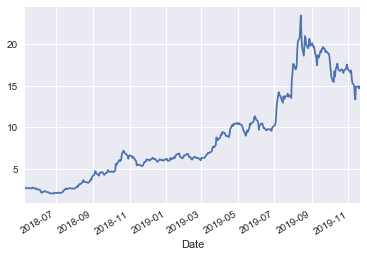

In [5]:
analise['Adj Close'].plot()

### Analise Fundamentalista
http://www.fundamentus.com.br/detalhes.php?papel=

In [19]:
dia = f'{datetime.datetime.now().year}-{datetime.datetime.now().month}-{datetime.datetime.now().day}'

Preco = analise['Adj Close'][-1]

NroAcoes = 702_805_000
VPatriLiq = 2_188_220_000
V_VP = Preco / VPatriLiq
LPA, VPA = 0.11 , 3.11
VIntrinseco = (22.5 * LPA * VPA) ** 0.5
JustoSimNao = (VIntrinseco - Preco) - 1

FundReport = pd.DataFrame(
    [
        [
        ticker,
        Preco,
        NroAcoes,
        VPatriLiq,
        round(V_VP, 5),
        LPA,
        VPA,
        VIntrinseco,
        JustoSimNao
        ]
        ],
    columns=[
        'Ticker',
        'Preco',
        'Numero Acoes',
        'Valor Patrimonial',
        'V/VP',
        'LPA',
        'VPA',
        'Valor Intrinseco',
        'Justo'
        ],
    index=[dia]
    )


FundReport

,Ticker,Preco,Numero Acoes,Valor Patrimonial,V/VP,LPA,VPA,Valor Intrinseco,Justo
2019-11-22,BIDI4,14.99,702805000,2188220000,0.0,0.11,3.11,2.774392,-13.215608


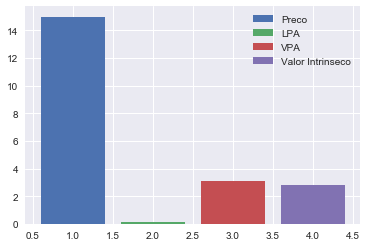

In [20]:
plt.bar(1, FundReport['Preco'], label='Preco')
plt.bar(2, FundReport['LPA'], label='LPA')
plt.bar(3, FundReport['VPA'], label='VPA')
plt.bar(4, FundReport['Valor Intrinseco'], label='Valor Intrinseco')

plt.legend()

plt.show()